# Kinetic Monte Carlo Simulation of Lignin Polymerization
Written by: Michael Orella <br>
2019 January 24 <br>
Updated by: Heather Mayes <br>
2019 November 07 <br>

The code in this notebook performs calculations analogous to those performed in ["Lignin-KMC: A Toolkit for Simulating Lignin Biosynthesis"](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b03534), which depend on the results that were obtained from [DFT calculations of monolignol coupling kinetics](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b02506).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# functions, global variables, and default values (described below) from the lignin-kmc Package 
from ligninkmc.event import Event
from ligninkmc.monomer import Monomer
from ligninkmc.create_lignin import (calc_rates, create_initial_monomers, create_initial_events, 
                                     create_initial_state, DEF_INI_RATE)
from ligninkmc.kineticMonteCarlo import run_kmc
from ligninkmc.visualization import generate_mol
from ligninkmc.analysis import analyze_adj_matrix
from ligninkmc.kmc_common import (DEF_E_A_KCAL_MOL, GROW, OX, BO4, B5, BB, B1, C5O4, AO4, C5C5,
                                  MONOMER, MONO_LIST, ADJ_MATRIX, BONDS)

#General Math and LinAlg
import numpy as np
import scipy as sp
import scipy.optimize

#Chemical Drawing
from rdkit.Chem import MolFromMolBlock
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import MolToImage
from IPython.display import display

#Plotting
import matplotlib.pyplot as plt

#Profiling and Performance
import cProfile
import time

#Parallelization
import joblib as par

## Input Data
The kinetic monte carlo code relies on rates of chemical reactions. The reactions that we are interested in here are the coupling of radicals on either individual monomers or oligomers respectively. The energetics necessary to compute the reaction rates were calculated by Terry Gani using [DFT methods](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b02506) for SG lignin and similar methods for C lignin. Once the reaction energies were calculated, they could converted to reaction rates using the Erying equation:
$$ r_i = \dfrac{k_BT}{h}\exp\left(-\dfrac{\Delta G_i}{k_BT}\right) $$

The these activation energies, as reported in the [Lignin-KMC paper](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b03534), [Tables S1 and S2](https://pubs.acs.org/doi/suppl/10.1021/acssuschemeng.9b03534/suppl_file/sc9b03534_si_001.pdf), are stored in the package's global variable DEF_E_A_KCAL_MOL (imported above). 

The user may use other values. The assignment of activation energies (in kcal/mol) to this global variable is shown below (using global variables for reaction types to help prevent typos from directly using strings) to provide a template for how to assign alternate values. Of course, the user only needs to (and must) supply activation energies only for the monomer types to be modeled and the reaction types to be modeled. Here, the bond names stands for creation of that bond.

Throughout the code, monomers are kept track of individually through the state, so there are no reaction degeneracies occuring, and bond events can be tracked faithfully.

The monomer types are:  0: guaiacol, 1: syringyl, 2: caffeoyl

In [3]:
# Calculate the rates of reaction in 1/s at the specified temp
temp = 298.15  # K
rxn_rates = calc_rates(temp, ea_kcal_mol_dict=DEF_E_A_KCAL_MOL)

# if the user has instead input activation energies in Joules per particle (e.g., as `my_ea_j_part_dict`), 
# instead invoke:
#    rxn_rates = calc_rates(temp, ea_j_part_dict=my_ea_j_part_dict)

## Code Performance
One of the first things that we were interested in reporting was the performance and scaling of this code package. This was done by replicating runs of the algorithm with different numbers of monomers included in the simulation under batch conditions.

In [4]:
# Here, we are testing with equal amount of S and G (no C)
times = []
sg_ratio = 1
pct_s = sg_ratio / (1 + sg_ratio)

test_vals = np.linspace(50, 150, num=3, dtype ='int32')
num_repeats = 5
for num_monos in test_vals:
    times.append([])
    for _ in range(num_repeats):
        # Generate the initial monomers and events (oxidation)
        monomer_draw = np.random.rand(num_monos)
        initial_monomers = create_initial_monomers(pct_s, num_monos, monomer_draw)
        initial_events = create_initial_events(monomer_draw, num_monos, pct_s, rxn_rates)
        
        # Set the state and add the option to join initial monomers
        initial_state = create_initial_state(initial_events, initial_monomers, num_monos)
        initial_events.append(Event(GROW, [], rate=DEF_INI_RATE, bond=sg_ratio))
        
        #Start timing the actual KMC part
        start = time.time()
        run_kmc(t_final=1e9, rates=rxn_rates, initial_state=initial_state,
                         initial_events=initial_events, sg_ratio=sg_ratio)
        end = time.time()
        times[-1].append(end-start)
    print(f'Time to complete simulation with {num_monos:5n} monomers: {np.sum(times[-1])/num_repeats:7.2f} seconds')

Time to complete simulation with    50 monomers:    0.28 seconds
Time to complete simulation with   100 monomers:    1.26 seconds
Time to complete simulation with   150 monomers:    2.91 seconds


Now we want to fit the times that we just calculated to a generic power law expression $t = aN^b$ to find the scaling of our algorithm.

In [5]:
meas_t = [np.mean(time) for time in times]
meas_n = test_vals

sim_t = lambda p, n: p[0] * np.power (n, p[1])
loss = lambda p: np.linalg.norm(sim_t(p, meas_n) - meas_t)

results = sp.optimize.minimize(loss, [1e-5, 2.5], bounds =[[0,1], [0,10]], options = {'disp': True})
print(results)

opt_p = results.x

      fun: 0.018307191606981514
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.83648270e-03, 7.02216063e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 324
      nit: 59
   status: 0
  success: True
        x: array([7.84190721e-05, 2.10029059e+00])


Now we should plot both the measured values and the fit all together

Text(200, 200, 'Measured')

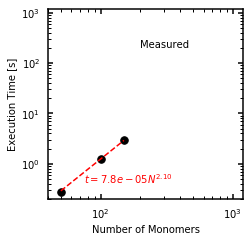

In [6]:
plt.figure(figsize=(3.5, 3.5))
plt.errorbar(test_vals, [np.mean(time) for time in times],
             yerr=[np.sqrt(np.var(time)) for time in times],
             capsize=3, ecolor='black', linestyle='None', marker='.', markerSize=15, color='black', zorder=1)
plt.plot(test_vals, sim_t(opt_p,meas_n), linestyle='--', color='r', linewidth=1.5, zorder=2)
plt.tick_params(axis='both', which ='major', labelsize=10, direction='in',
                pad=8, top = True, right=True, width=1.5, length=5)
plt.tick_params(axis='both', which='minor', direction='in',
                pad=8, top=True, right=True, width=1, length=3)
ax = plt.gca()
[ax.spines[i].set_linewidth(1.5) for i in ['top', 'right', 'bottom', 'left']]
ax.fontsize = 10
plt.xlabel('Number of Monomers', fontsize=10)
plt.ylabel('Execution Time [s]', fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.2, 1200])
plt.xlim([40, 1200])
plt.text(75, 0.4, f'$t = {opt_p[0]:3.1e}N^{{ {opt_p[1]:4.2f} }}$', fontsize=10, color='red')
plt.text(200, 200, r'Measured', fontsize=10, color='black')
# plt.savefig('../plots/performance.svg', format='svg', transparent=True, bbox_inches='tight')

## Example KMC Runs
Small examples of running the algorithm for KMC, using both SG lignin and C lignin.

### SG Lignin
Run an example starting with 2 monomers and an S to G ratio of 1

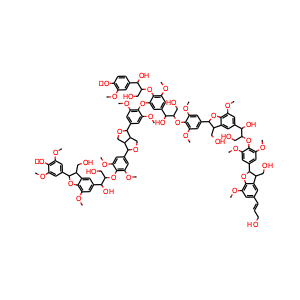

In [7]:
num_monos = 2
sg_ratio = 1
pct_s = sg_ratio / (1 + sg_ratio)

monomer_draw = np.random.rand(num_monos)
initial_monomers = create_initial_monomers(pct_s, num_monos, monomer_draw)
initial_events = create_initial_events(monomer_draw, num_monos, pct_s, rxn_rates)
initial_state = create_initial_state(initial_events, initial_monomers, num_monos)
initial_events.append(Event(GROW, [], rate=DEF_INI_RATE, bond=sg_ratio))

result = run_kmc(n_max=10, t_final=1, rates=rxn_rates, initial_state=initial_state, 
                 initial_events=initial_events, sg_ratio=sg_ratio)
nodes = result[MONO_LIST]
adj = result[ADJ_MATRIX]
block = generate_mol(adj, nodes)
mol = MolFromMolBlock(block)
Compute2DCoords(mol)
display(MolToImage(mol, molSize=(1400,400)))

### C lignin
Run an example with 2 monomers but using the C lignin energies

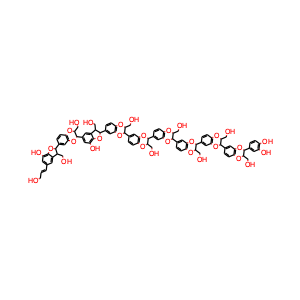

In [8]:
num_monos = 2

initial_monomers = [Monomer(2, i) for i in range(num_monos)]
initial_events = [Event(OX, [i], rxn_rates[OX][2][MONOMER]) for i in range(num_monos)]
ini_state = create_initial_state(initial_events, initial_monomers, num_monos)
events = {initial_events[i] for i in range(num_monos)}
events.add(Event(GROW, [], rate=DEF_INI_RATE))

result = run_kmc(n_max=10, t_final=1, rates=rxn_rates, initial_state=ini_state,
                 initial_events=sorted(events))

nodes = result[MONO_LIST]
adj = result[ADJ_MATRIX]
block = generate_mol(adj, nodes)
mol = MolFromMolBlock(block)
Compute2DCoords(mol)
display(MolToImage(mol, molSize=(1400,400)))

## Sensitivity Analyses Examples
The meat of the results and discussion for our paper lay in the predictions of how lignin composition should change with different sets of parameters used for lignification. These calculations were performed on desktop hardware over about a week's period, but for the sake of explanation, shorter examples are used here. We investigated the impact of S to G ratio and addition rate primarily.

### SG Batch Sensitivity
The first analysis performed is the dependence of monomer yields and bond contents on SG ratio, where we selected multiple SG ratios between 0.1 and 10 and ran the simulations for these scenarios.

In [9]:
sg_opts = [0.1, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 10]
num_repeats = 5

fun = par.delayed(run_kmc)
sg_result_list = []

for sg_ratio in sg_opts:
    # Set the percentage of S
    pct_s = sg_ratio / (1 + sg_ratio)
    
    # Make choices about what kinds of monomers there are and create them
    num_monos = 200
    monomer_draw = np.random.rand(num_monos)
    initial_monomers = create_initial_monomers(pct_s, num_monos, monomer_draw)
    
    # Initialize the monomers, events, and state
    initial_events = create_initial_events(monomer_draw, num_monos, pct_s, rxn_rates)
    initial_state = create_initial_state(initial_events, initial_monomers, num_monos)

    results = par.Parallel(n_jobs = 4)([fun(n_max=num_monos, t_final=1, rates=rxn_rates, 
                                            initial_state=initial_state, initial_events=initial_events)
                                        for _ in range(num_repeats)])
    
    sg_result_list.append(results)
    print('Completed sensitivity iteration for S to G ratio: {:.2f}'.format(sg_ratio))

    
    t = time.localtime()
    print('Finished on {}-{:02d}-{:02d} at {:02d}:{:02d}:{:02d}\n'.format(t.tm_year, t.tm_mon, t.tm_mday,
                                                                        t.tm_hour, t.tm_min, t.tm_sec))

Completed sensitivity iteration for S to G ratio: 0.10
Finished on 2019-11-07 at 14:59:31

Completed sensitivity iteration for S to G ratio: 0.20
Finished on 2019-11-07 at 14:59:48

Completed sensitivity iteration for S to G ratio: 0.25
Finished on 2019-11-07 at 15:00:03

Completed sensitivity iteration for S to G ratio: 0.33
Finished on 2019-11-07 at 15:00:21

Completed sensitivity iteration for S to G ratio: 0.50
Finished on 2019-11-07 at 15:00:36

Completed sensitivity iteration for S to G ratio: 1.00
Finished on 2019-11-07 at 15:00:49

Completed sensitivity iteration for S to G ratio: 2.00
Finished on 2019-11-07 at 15:01:01

Completed sensitivity iteration for S to G ratio: 3.00
Finished on 2019-11-07 at 15:01:11

Completed sensitivity iteration for S to G ratio: 4.00
Finished on 2019-11-07 at 15:01:21

Completed sensitivity iteration for S to G ratio: 5.00
Finished on 2019-11-07 at 15:01:30

Completed sensitivity iteration for S to G ratio: 10.00
Finished on 2019-11-07 at 15:01:39

We now aggregate the results that we obtained in the form of adjacency matrices and monomer lists and times to meaningful values of monomer yields and bond contents.|

In [10]:
num_sg_opts = len(sg_opts)
analysis = []

for i in range(num_sg_opts):
    sg_results = sg_result_list[i]
    cur_adjs = [sg_results[j][ADJ_MATRIX] for j in range(num_repeats)]
    analysis.append(par.Parallel(n_jobs = 4)(par.delayed(analyze_adj_matrix)(adjacency=cur_adjs[j])
                                              for j in range(num_repeats)))                                        
    t = time.localtime()
    print('Finished S:G {:5.2f} on {}-{:02d}-{:02d} at '
          '{:02d}:{:02d}:{:02d}'.format(sg_opts[i], t.tm_year, t.tm_mon, t.tm_mday, t.tm_hour, t.tm_min, t.tm_sec))

Finished S:G  0.10 on 2019-11-07 at 15:01:40
Finished S:G  0.20 on 2019-11-07 at 15:01:40
Finished S:G  0.25 on 2019-11-07 at 15:01:41
Finished S:G  0.33 on 2019-11-07 at 15:01:41
Finished S:G  0.50 on 2019-11-07 at 15:01:42
Finished S:G  1.00 on 2019-11-07 at 15:01:42
Finished S:G  2.00 on 2019-11-07 at 15:01:43
Finished S:G  3.00 on 2019-11-07 at 15:01:43
Finished S:G  4.00 on 2019-11-07 at 15:01:44
Finished S:G  5.00 on 2019-11-07 at 15:01:44
Finished S:G 10.00 on 2019-11-07 at 15:01:45


Now as an example, we will look at the distribution of monomer yields that we got, and then summarize that distribution with the sample mean and standard deviation, which will be used for all of the subsequent analyses. To visualize these results, we first need to extract the information from the analysis data structure, and normalize the data to the total number of monomers or total number of bonds.

In [18]:
betaO4_bonds = [[analysis[j][i][BONDS][BO4]/sum(analysis[j][i][BONDS].values())
                for i in range(num_repeats)] for j in range(num_sg_opts)]
beta5_bonds = [[analysis[j][i][BONDS][B5]/sum(analysis[j][i][BONDS].values())
                for i in range(num_repeats)] for j in range(num_sg_opts)]
betabeta_bonds = [[analysis[j][i][BONDS][BB]/sum(analysis[j][i][BONDS].values())
                  for i in range(num_repeats)] for j in range(num_sg_opts)]
beta1_bonds = [[analysis[j][i][BONDS][B1]/sum(analysis[j][i][BONDS].values())
               for i in range(num_repeats)] for j in range(num_sg_opts)]
C5O4_bonds = [[analysis[j][i][BONDS][C5O4]/sum(analysis[j][i][BONDS].values())
              for i in range(num_repeats)] for j in range(num_sg_opts)]
alphaO4_bonds = [[analysis[j][i][BONDS][AO4]/sum(analysis[j][i][BONDS].values())
                 for i in range(num_repeats)] for j in range(num_sg_opts)]
fivefive_bonds = [[analysis[j][i][BONDS][C5C5]/sum(analysis[j][i][BONDS].values())
                  for i in range(num_repeats)] for j in range(num_sg_opts)]

av_bo4_bonds = [np.mean(hist) for hist in betaO4_bonds]
std_bo4_bonds = [np.sqrt(np.var(hist)) for hist in betaO4_bonds]

av_b5_bonds = [np.mean(hist) for hist in beta5_bonds]
std_b5_bonds = [np.sqrt(np.var(hist)) for hist in beta5_bonds]

av_bb_bonds = [np.mean(hist) for hist in betabeta_bonds]
std_bb_bonds = [np.sqrt(np.var(hist)) for hist in betabeta_bonds]

av_b1_bonds = [np.mean(hist) for hist in beta1_bonds]
std_b1_bonds = [np.sqrt(np.var(hist)) for hist in beta1_bonds]

av_5o4_bonds = [np.mean(hist) for hist in C5O4_bonds]
std_5o4_bonds = [np.sqrt(np.var(hist)) for hist in C5O4_bonds]

av_ao4_bonds = [np.mean(hist) for hist in alphaO4_bonds]
std_ao4_bonds = [np.sqrt(np.var(hist)) for hist in alphaO4_bonds]

av_55_bonds = [np.mean(hist) for hist in fivefive_bonds]
std_55_bonds = [np.sqrt(np.var(hist)) for hist in fivefive_bonds]

With this aggregation complete, we now plot the histograms of beta04 bond yields for 3 cases of SG ratios - 0.1, 1, and 10. With so few repeats, these histograms look very poor, but with greater repeats there is a much clearer trend and approximation of the normal distribution - which justifies the use of sample norm and standard deviation as summary statistics.

No handles with labels found to put in legend.


[0.8218390804597702, 0.8083832335329342, 0.7988505747126436, 0.8248587570621468, 0.825]


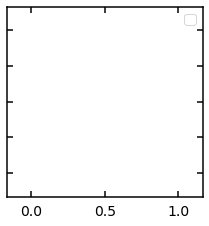

In [25]:
plt.figure(figsize=(3.5, 3.5))
print(max(betaO4_bonds[0], betaO4_bonds[5], betaO4_bonds[10]))


plt.hist(betaO4_bonds[0], bins=np.linspace(0,0.05,1), density=1, facecolor='black', alpha=0.5, edgecolor='black', label='S/G=0.1')
plt.hist(betaO4_bonds[5], bins=np.linspace(0,0.05,1), density=1, facecolor='red', alpha=0.5, edgecolor='black', label='S/G=1')
plt.hist(betaO4_bonds[10], bins=np.linspace(0,0.05,1), density=1, facecolor='blue', alpha=0.5, edgecolor='black', label='S/G=10')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top', 'right', 'bottom', 'left']]
plt.gca().tick_params(axis='both', which='major', labelsize=14, direction='in', pad=8, top=True, right=True, width=1.5, length=6)
# plt.xlim([0.0, 1.0])
plt.gca().set_yticklabels([''] * len(plt.gca().get_yticklabels()))
# plt.xlabel('Monomer Yield [-]', fontsize=14)
plt.legend(fontsize=14, loc='best')

As mentioned above, with more repeats these distributions approach the normal distribution. In addition, if we want to add more sensitivity results to this plot, it starts to look messier and more crowded. Therefore, it becomes much easier to use the mean and variance of our samples as summary statistics, and just plot these values (using the standard deviation as the error bar on every point).

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,0.2]);

The monomer yields plot above is easy, because there is just one trend that we look at. For this instance, that trend is fairly messy, again because there are fewer repeats and fewer monomers in each simulation, but the idea is still the same.

Let us now examine the bond contents that were predicted from this simulation.

In [ ]:
colors = [(0, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0.6, 0), (0.6, 0, 0.6), (1, 0.549, 0), 
          (0, 0.6, 0.6), (1, 0.8, 0), (0.6078, 0.2980, 0), (0.6, 0, 0), (0, 0, 0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts, av_bo4Content, yerr=std_bo4Content, linestyle='none', marker='.',
             markersize=10, markerfacecolor=colors[0], markeredgecolor=colors[0], label='bo4',
             capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts, av_bbContent, yerr=std_bbContent, linestyle='none', marker='.',markersize=10, markerfacecolor=colors[1], markeredgecolor=colors[1], label='bb', capsize=3, ecolor=colors[1])
plt.errorbar(sg_opts, av_b5Content, yerr=std_b5Content, linestyle='none', marker='.',markersize=10, markerfacecolor=colors[2], markeredgecolor=colors[2], label='b5', capsize=3, ecolor=colors[2])
plt.errorbar(sg_opts, av_b1Content, yerr=std_b1Content, linestyle='none', marker='.',markersize=10, markerfacecolor=colors[3], markeredgecolor=colors[3], label='b1', capsize=3, ecolor=colors[3])
plt.errorbar(sg_opts, av_5o4Content, yerr=std_5o4Content, linestyle='none', marker='.',markersize=10, markerfacecolor=colors[4], markeredgecolor=colors[4], label='5o4', capsize=3, ecolor=colors[4])
plt.errorbar(sg_opts, av_ao4Content, yerr=std_ao4Content, linestyle='none', marker='.',markersize=10, markerfacecolor=colors[5], markeredgecolor=colors[5], label='ao4', capsize=3, ecolor=colors[5])
plt.errorbar(sg_opts, av_55Content, yerr=std_55Content, linestyle='none', marker='.',markersize=10, markerfacecolor=colors[6], markeredgecolor=colors[6], label='55', capsize=3, ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5, length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1, length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Addition rate sensitivity
We will now perform the same task on different addition rates

In [ ]:
addrates = np.logspace(4,14,21)

fun = par.delayed(kmc.run)
resultsToSave = []
     
for rate in addrates:
    #Set the percentage of S
    sg = 1
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [event ( 'ox' , [i] , rxn_rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(event('grow',[],rate = rate,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rxn_rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(rate))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

In [ ]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

In [ ]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields]  
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content]
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content]
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent]
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content]
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content]
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content]
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(addrates,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('Addition Rate [Hz]',fontsize=14)
plt.ylim([0.0,0.5]);

In [ ]:
colors = [(0, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0.6, 0), (0.6, 0, 0.6), (1, 0.549, 0), 
          (0, 0.6, 0.6), (1, 0.8, 0), (0.6078, 0.2980, 0), (0.6, 0, 0), (0, 0, 0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(addrates,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(addrates,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(addrates,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(addrates,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(addrates,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(addrates,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(addrates,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('Add Rate [Hz]',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity
We will now perform the same task on different SG ratios with a very slow addition rate

In [ ]:
sg_opts = [0.1, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 10]

fun = par.delayed(run_kmc)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rxn_rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e4,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rxn_rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

In [ ]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave)
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

In [ ]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

In [ ]:
colors = [(0, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0.6, 0), (0.6, 0, 0.6), (1, 0.549, 0), 
          (0, 0.6, 0.6), (1, 0.8, 0), (0.6078, 0.2980, 0), (0.6, 0, 0), (0, 0, 0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity 1e7 Hz
We will now perform the same task on different SG ratios with three different addition rates

In [ ]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(run_kmc)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rxn_rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e7,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rxn_rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

In [ ]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ', (str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

In [ ]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

In [ ]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity 1e9 Hz
We will now perform the same task on different SG ratios with three different addition rates

In [ ]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(run_kmc)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rxn_rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e9,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rxn_rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

In [ ]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave)
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

In [ ]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

In [ ]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity 1e11 Hz
We will now perform the same task on different SG ratios with three different addition rates

In [ ]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(run_kmc)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rxn_rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e11,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rxn_rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

In [ ]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

In [ ]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

In [ ]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

In [ ]:
colors = [(0,0,0), (1,0,0), (0,0,1), (0,0.6,0), (0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);